# Estimating Probability Density from Data

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import pandas as pd
import os.path
import subprocess

Load the scikit-learn modules we need:

In [3]:
from sklearn import neighbors, mixture

We will also use the [astroML package](http://www.astroml.org/) below:

In [ ]:
%pip install astroML
import astroML.density_estimation

Helpers for Getting, Loading and Locating Data

In [5]:
def wget_data(url: str):
    local_path = './tmp_data'
    p = subprocess.Popen(["wget", "-nc", "-P", local_path, url], stderr=subprocess.PIPE, encoding='UTF-8')
    rc = None
    while rc is None:
      line = p.stderr.readline().strip('\n')
      if len(line) > 0:
        print(line)
      rc = p.poll()

def locate_data(name, check_exists=True):
    local_path='./tmp_data'
    path = os.path.join(local_path, name)
    if check_exists and not os.path.exists(path):
        raise RuxntimeError('No such data file: {}'.format(path))
    return path

## <span style="color:Orange">Get Data</span>

In [ ]:
wget_data('https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/data/cluster_d_data.hf5')
wget_data('https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/data/blobs_data.hf5')
wget_data('https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/data/blobs_targets.hf5')

## <span style="color:Orange">Load and Examine Data</span>

In [7]:
cluster_data  = pd.read_hdf(locate_data('cluster_d_data.hf5'))
blobs_data    = pd.read_hdf(locate_data('blobs_data.hf5'))
blobs_targets = pd.read_hdf(locate_data('blobs_targets.hf5'))

Let's examine this new (N,D) = (2000,3) dataset using a `pairplot` with each sample colored to show the underlying generative model, consisting of three overlapping Gaussian blobs:

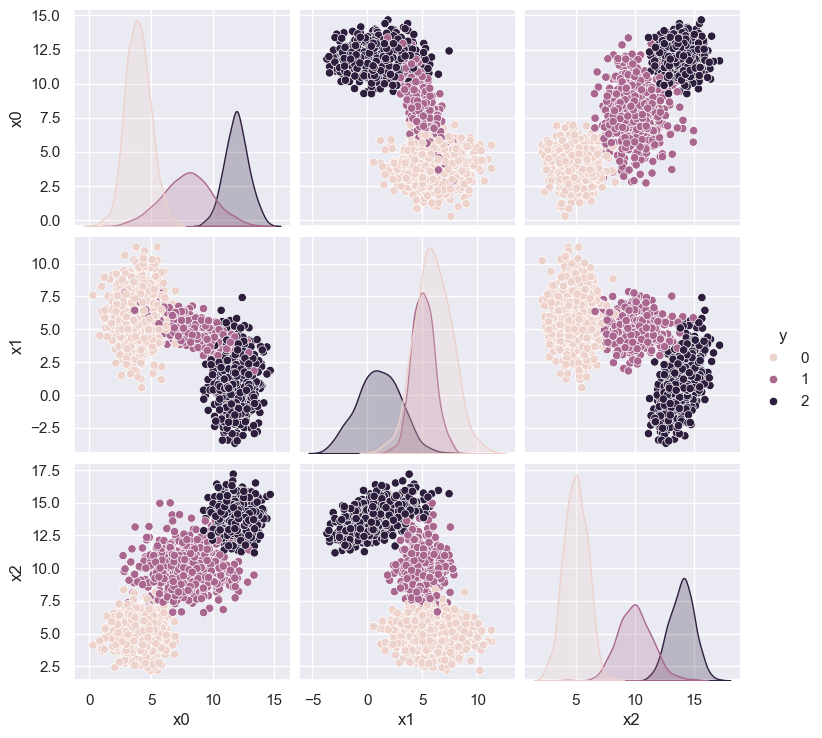

In [8]:
def plot_blobs(labels):
    Xy = blobs_data.copy()
    Xy['y'] = labels
    sns.pairplot(Xy, vars=('x0', 'x1', 'x2'), hue='y')
    
plot_blobs(labels=blobs_targets['y'])

## <span style="color:Orange">From Histograms to Kernel Density Estimates</span>

We will start with 1D examples, so drop the other 2 columns:

In [9]:
blobs1d = blobs_data.drop(columns=['x1', 'x2'])

A histogram is a useful visualization of the 1D distribution of a feature. However, here we are after something more quantitative: a <span style="color:violet">density estimate</span>. The underlying assumption of density estimation is that our data $X$ is a random sampling of some underlying continuous probability density function $P(x)$,

$$ \Large
X \sim P(x) \; .
$$

The task of <span style="color:violet">density estimation</span> is then to empirically estimate $P(x)$ from the observed $X$. This will always be an error prone process since, generally, $P(x)$ contains infinitely more information than the finite $X$ that we cannot hope to recover. Our goal is therefore to do the best possible job with the limited information available.

A histogram usually counts the number $n_i$ of samples falling into each of its $B$ predefined bins $b_{i-1} \le x \lt b_i$ (note that there are $B$ counts $n_i$ and $B+1$ bin edges $b_i$). This convention has the advantage that the error on each bin value is described by the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution), which becomes indistinguishable from the [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) for large counts $n_i$, leading to the rule of thumb

$$ \Large
n_i \pm \sqrt{n_i} ~~~~~~~~~~~~~~~~~(\text{Gaussian statistics per bin } i \; .)
$$

In order to estimate probability density, we convert each bin count $n_i$ into a corresponding density

$$ \Large
\rho_i = \frac{n_i}{N \left(b_i - b_{i-1}\right)}
$$

where 

$$ \Large
N = \sum_{i=1}^B n_i
$$

is the usual total number of samples, so that

$$ \Large
\sum_{i=1}^B \rho_i (b_i - b_{i-1}) \simeq \int \rho(x)\,dx = 1 \; .
$$

Use `normed=True` with `plt.hist` or `norm_hist=True` with `sns.distplot` to request this convention.

Histogram bins are often equally spaced,

$$ \Large
b_i = x_{\min} + (x_{\max} - x_{\min}) \frac{i}{B} \quad , \quad i = 0, 1, \ldots, B \; .
$$

However, this is not necessary and non-uniform binning (e.g., logarithmic spacing) can be more effective when sample density varies significantly.

We will use the following function to compare histograms with other density estimators (as usual, you can ignore the details):

In [10]:
def estimate_density1d(X, limits=(0, 15), bins=16, kernels=None):
    # Prepare the fixed binning to use.
    bins = np.linspace(*limits, bins) if bins else 'fd'
    # Plot a conventional histogram.
    sns.displot(X, label='hist', alpha=.4, bins=bins, legend=False, stat='density', rug=True, rug_kws=dict(lw=4))

    if kernels:
        # Calculate and plot a KDE with bandwidth = binsize/2.
        bw = 0.5 * (bins[1] - bins[0])
        x_smooth = np.linspace(*limits, 500)
        for kernel in kernels.split(','):
            fit = neighbors.KernelDensity(kernel=kernel, bandwidth=bw).fit(X.values)
            y_smooth = np.exp(fit.score_samples(x_smooth.reshape(-1, 1)))
            plt.plot(x_smooth, y_smooth, label=kernel)
    plt.xlim(*limits)
    plt.ylabel('Probability density')
    plt.legend(fontsize='large')

Let's first compare histograms of very small samples (by restricting the rows of `blobs1d`). Note how the bin locations $b_i$ are predefined, independently of the data.

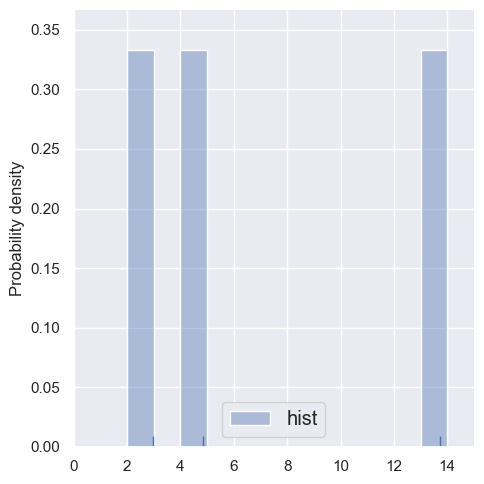

In [11]:
estimate_density1d(blobs1d.iloc[:3])

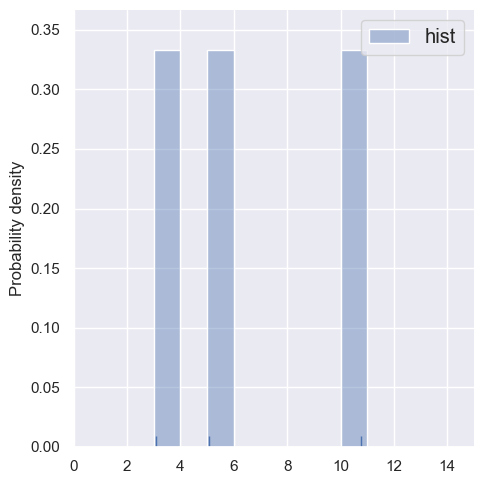

In [12]:
estimate_density1d(blobs1d.iloc[3:6])

These histogram density estimates are not very useful because we have chosen fixed bins that are too small for so few samples.  As an alternative, we can use the data to determine the binning, e.g. with the [Freedman-Diaconnis rule](https://en.wikipedia.org/wiki/Freedman-Diaconis_rule) that `sns.distplot` uses when `bins=None`:

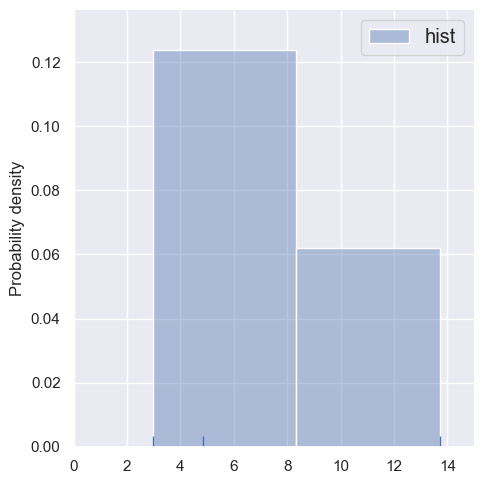

In [13]:
estimate_density1d(blobs1d.iloc[:3], bins=None)

This is an improvement, but an even better use of the data is to center the contribution of each sample on the sample itself, which is the key idea of **kernel density estimation**:

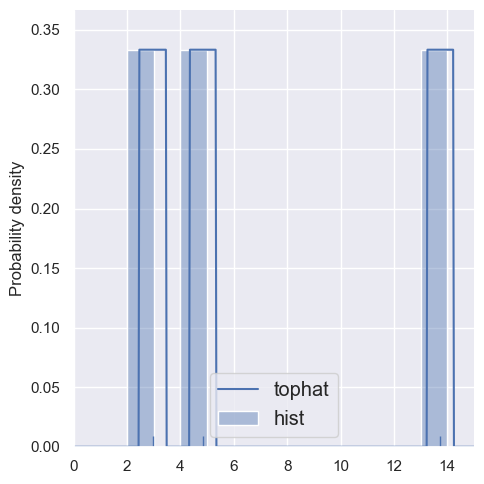

In [14]:
estimate_density1d(blobs1d.iloc[:3], kernels='tophat')

There is nothing special about the "tophat" shape assigned to each sample, which we call the **kernel**, and other choices are equally valid, e.g.

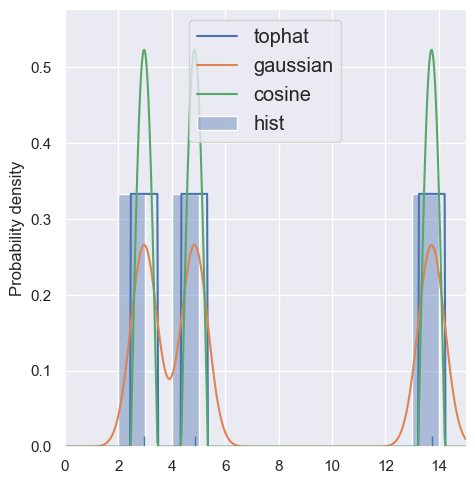

In [15]:
estimate_density1d(blobs1d.iloc[:3], kernels='tophat,gaussian,cosine')

___<span style="color:violet">NOTE</span>___: this <span style="color:violet">kernel</span> is not the same as the <span style="color:violet">kernel functions</span> we discussed earlier:
 - <span style="color:violet">kernel</span>: centered function used to "spread" each sample for a density estimate.
 - <span style="color:violet">kernel function</span>: similarity measure used to efficiently compute dot products in a higher-dimensional space.

With more samples, the individual kernels blend together and the results are less sensitive to the choice of kernel (and agree better with a histogram):

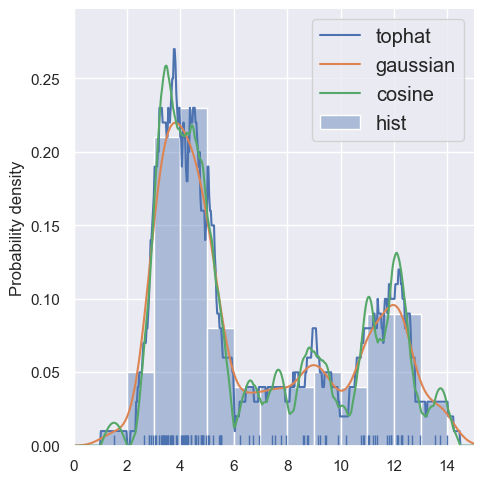

In [16]:
estimate_density1d(blobs1d.iloc[:100], kernels='tophat,gaussian,cosine')

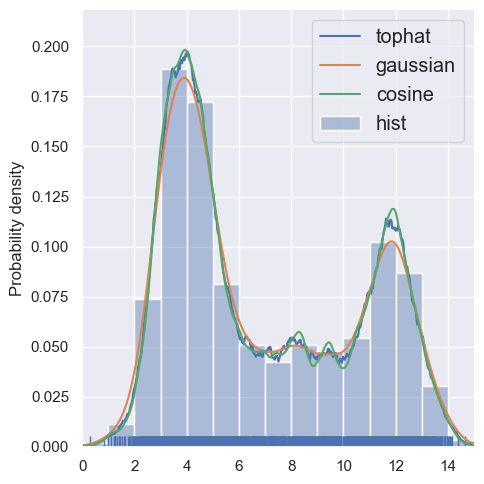

In [17]:
estimate_density1d(blobs1d.iloc[:2000], kernels='tophat,gaussian,cosine')

The [sklearn implementation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html) of [kernel density estimation (KDE)](https://en.wikipedia.org/wiki/Kernel_density_estimation) uses the familiar calling pattern, with two significant hyperparameters:

In [18]:
fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=1.0).fit(blobs1d)

Refer to the implementation of `estimate_density` above for details on how to calculate and plot the estimated smooth $P(x)$ from the resulting `fit` object.

Compare KDE of 3 samples with bandwidths of 1 and 2. Note that the spreading of each sample is always normalized, so doubling the width halves the height.

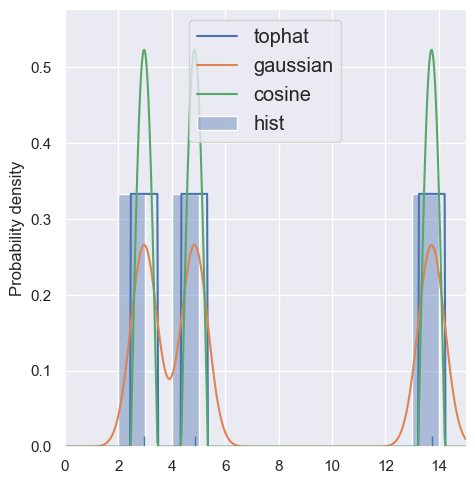

In [19]:
estimate_density1d(blobs1d.iloc[:3], kernels='tophat,gaussian,cosine')

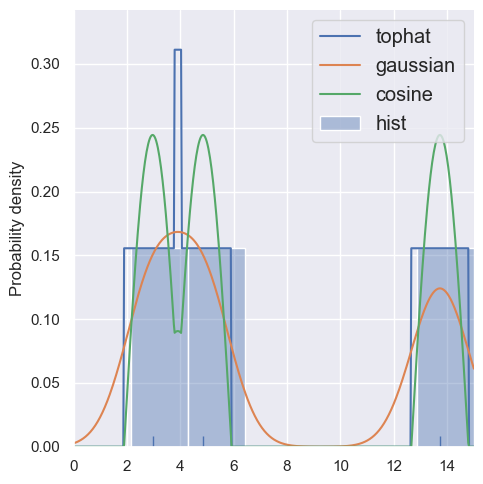

In [20]:
estimate_density1d(blobs1d.iloc[:3], kernels='tophat,gaussian,cosine', bins=8)

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:violet">DISCUSS</span>___: How should the bandwidth be tuned, if at all, to account for:
- A doubling of the number of samples.

- A different underlying probability density $P(x)$.

The purpose of the kernel is to spread each sample to fill in the gaps due to finite data. In other words, we are approximating what we would expect to measure with an infinite dataset. With this picture, the bandwidth should be related to the mean gap size, which should ~halve when the sample size is doubled.

Just knowing that the probability density has changed does not provide any guidance on how to change the bandwidth. However, we might also know *how* it has changed by looking at the data.  For example, if the data appears much smoother, then increasing the `bandwidth` would be justified. Conversely, data with sharp edges or narrow peaks would benefit from a smaller bandwidth to preserve those features.

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

For further reading about histograms and KDE for 1D data, see [this blog post](https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html).

## <span style="color:Orange">Multidimensional KDE</span>

KDE is not limited to 1D and we can replace our centered 1D kernels with centered multi-dimensional blobs to the estimate the underlying probability density $P(\vec{x})$ of any data.

If you just want to *see* a KDE of your data, without needing to do any calculations with it, a seaborn [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) is the easiest solution for 1D and 2D, e.g.

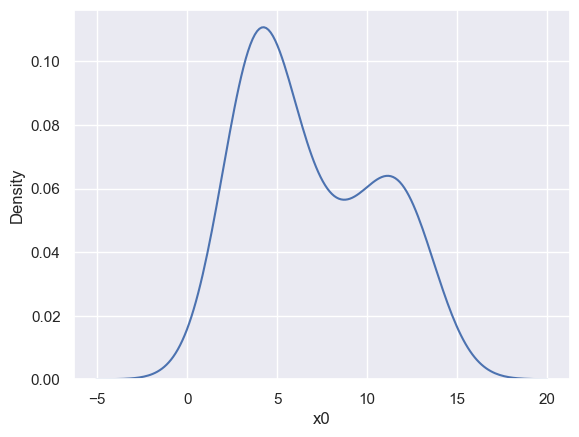

In [21]:
sns.kdeplot(blobs_data['x0'], bw_method=1, bw_adjust=0.5)
plt.show()

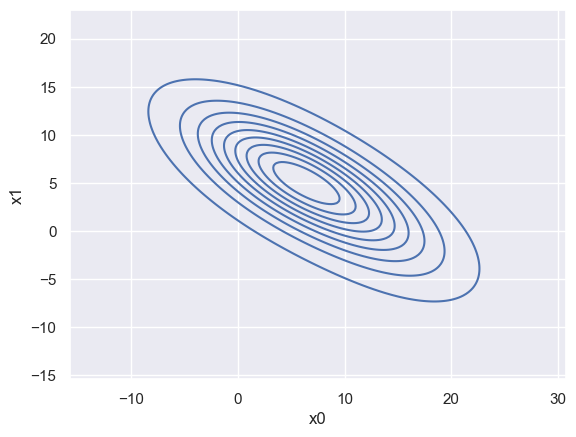

In [22]:
sns.kdeplot(blobs_data, x='x0', y='x1', bw_method=1, bw_adjust=1.5)
plt.show()

The `sns.displot` and `sns.jointplot` visualizations can also superimpose a KDE in 1D and 2D, although with less convenient control of the hyperparameters, e.g.

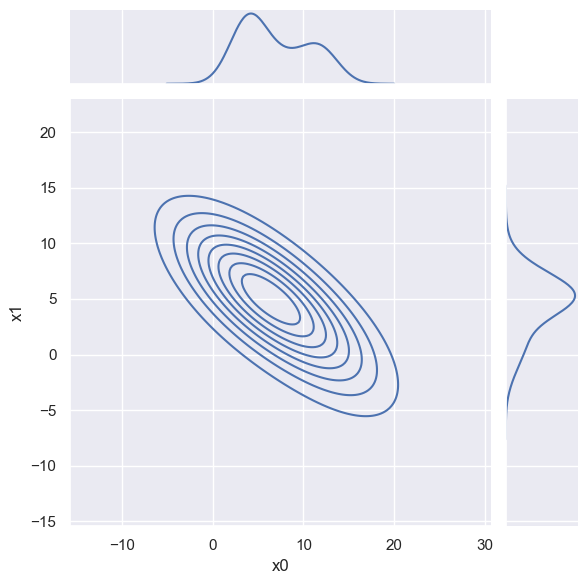

In [23]:
sns.jointplot(blobs_data, x='x0', y='x1', kind='kde',
              joint_kws=dict(bw_method=1, bw_adjust=1.5, thresh=False),
              marginal_kws=dict(bw_method=1, bw_adjust=0.5))
plt.show()

For more quantitative applications, first run a `KernelDensity` fit with the usual calling convention:

In [24]:
fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data.values)

You can then either evaluate the fit at any arbitrary point in the sample space, e.g.

In [25]:
np.exp(fit.score_samples([[5, 5, 5], [10, 5, 10], [10, 10, 10]]))

array([0.00495426, 0.00244693, 0.        ])

Note that `score_samples()` returns $\log P(x)$, which provides better dynamic range in a fixed-size floating point number, so should be wrapped in `np.exp()` to recover $P(x)$.

Alternatively, you can generate random samples from the estimated $P(x)$ using, e.g.

In [26]:
gen = np.random.RandomState(seed=123)
fit.sample(n_samples=5, random_state=gen)

array([[ 4.94902631,  7.41065346, 10.97821932],
       [ 3.87363289,  3.80451607,  4.50283055],
       [11.09145063,  1.00812938, 13.29987882],
       [10.59026763,  2.55629527, 14.14410438],
       [ 8.9555949 ,  5.35446964,  8.37578739]])

This second option is useful as a building block for a Monte Carlo simulation or integration.

When going beyond 1D KDE, a single bandwidth hyperparameter is not sufficient since it assumes that the gaps between samples are both:
 - isotropic, i.e., the same in all directions, and

 - homogeneous, i.e., the same at all locations in the sample space.
 
Neither of these is generally true, as we can see from a 2D scatter plot of 100 samples:

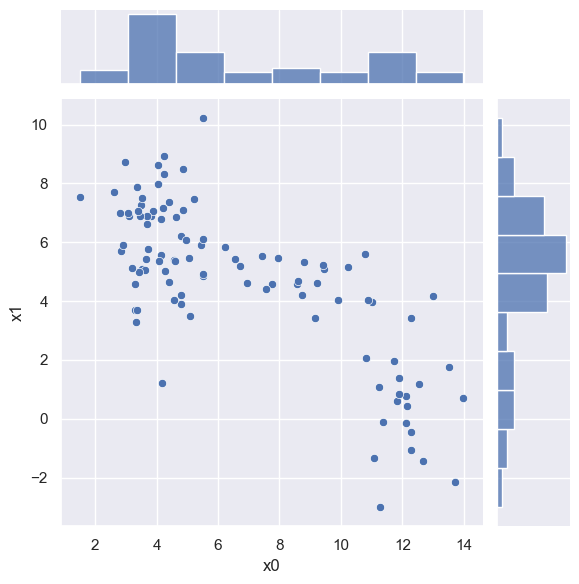

In [27]:
sns.jointplot(blobs_data.iloc[:100], x='x0', y='x1', kind='scatter')
plt.show()

The most general Gaussian kernel would have $D(D+1)/2$ shape parameters (covariance matrix elements) that vary slowly over the $N$-dimensional parameter space, instead of a single `bandwidth` parameter.

There are more sophisticated implementations of KDE that use the data itself to estimate kernels that are neither isotropic or homogeneous, e.g., in the [statsmodels package](http://www.statsmodels.org/devel/generated/statsmodels.nonparametric.kernel_density.KDEMultivariate.html). For an in-depth comparison of sklearn KDE with other python implementations, see [this blog post](https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/).

However, there is no magic in KDE and the problem is fundamentally error prone so using simpler methods whose limitations are easier to understand is often preferable.  The best way to improve any density estimate is always to add more data!

## <span style="color:Orange">Gaussian Mixture Models</span>

The KDE approach is often described as *non-parametric* since the fit is driven by the data without any free parameters of a goal function. Next, we will constrast KDE with <span style="color:violet">Gaussian mixture models</span> (GMM) which have many free parameters.

___<span style="color:violet">SIDE NOTE</span>___: I don't find the "non-parametric" distinction very meaningful since any useful method always has significant hyperparameters.

GMM assumes the following parametric form for the probability density:

$$ \Large
P(\vec{x}) = \sum_{k=1}^{K}\, \omega_k G(\vec{x} ; \vec{\mu}_k, C_k)
$$

where $G$ is a normalized $D$-dimensional Gaussian (normal) distribution:

$$ \Large
G(\vec{x} ; \vec{\mu}, C) = \left(2\pi\right)^{-D/2}\,\left| C\right|^{-1/2}\,
\exp\left[  -\frac{1}{2} \left(\vec{x} - \vec{\mu}\right)^T C^{-1} \left(\vec{x} - \vec{\mu}\right) \right]
$$

and the weights $\omega_k$ are normalized:

$$ \Large
\sum_{k=1}^K\, \omega_k = 1 \; .
$$

Note that this compact formula glosses over a lot of details:
- Notation: determinant $|C|$, inverse $C^{-1}$, transpose $\left(\vec{x} - \vec{\mu}\right)^T$.
- The object $C$ is a $D\times D$ covariance matrix that must be positive definite (and hence invertible).
- The argument of the exponential is a scalar computed from a vector-matrix expression.

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:violet">DISCUSS</span>___: How many independent parameters are there when fitting the density of $N\times D$ data to $K$ Gaussians?

Each mean vector $\vec{\mu}_k$ has $D$ independent parameters.  Each covariance matrix $C_k$ has $D(D+1)/2$ independent parameters, due to the positive definite requirement, which implies $C^T = C$.  Finally, the $K$ weights $\omega_k$ only contribute $K-1$ independent parameters because they sum to one.

Therefore the total number of independent parameters for $K$ Gaussians is:

$$ \Large
(K - 1) + K D + K \frac{D(D+1)}{2} \; .
$$

For example, `blobs_data` has $D=3$ and $K=3$ leading to 29 parameters. Note that the number of parameters does not depend on the number of samples $N$, but our ability to accurately estimate all of these parameters certainly will.

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

GMM is another example of a machine-learning algorithm that can be efficiently solved with the Expectation-Maximization (EM) technique.  The [sklearn implementation](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) uses the familiar calling pattern with the number of desired components $K$ as its main hyperparameter:

In [28]:
fit = mixture.GaussianMixture(n_components=3).fit(blobs_data.values)

As with KDE, we have two options for using the resulting density estimate:

In [29]:
np.exp(fit.score_samples([[5, 5, 5], [10, 5, 10], [10, 10, 10]]))

array([8.91534159e-03, 2.43144309e-03, 2.90695614e-17])

In [30]:
fit.random_state = np.random.RandomState(seed=1)
fit.sample(n_samples=5)

(array([[ 3.35920221,  6.8992151 ,  6.23358241],
        [ 5.28533637,  9.77821911,  3.46514107],
        [ 4.33487451,  5.45480832,  6.40348508],
        [11.82288738,  3.12351438,  9.23645078],
        [10.7868612 , -1.14385655, 13.29797882]]),
 array([0, 0, 0, 1, 2]))

Note that `fit.sample()` does not allow you to pass in your random state directly, which I consider a [bug](https://github.com/scikit-learn/scikit-learn/issues/10539), and returns true labels (0,1,2) for the generated samples in addition to the samples themselves.

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:violet">EXERCISE:___</span> Perform a 3-component 1D GMM fit to `blobs1d` and make a plot to compare with a KDE fit using a Gaussian kernel with bandwidth of 0.5. (Hint: refer to `estimate_density1d` above).

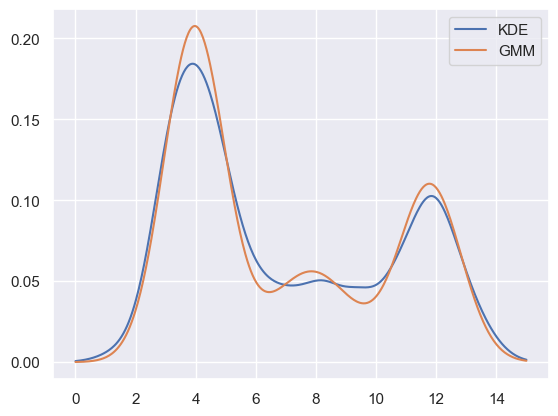

In [31]:
# Use the same fine grid of x values to calculate P(x) on.
x = np.linspace(0, 15, 500)
# Calcuate the KDE estimate of P(x)
kde_fit = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.5).fit(blobs1d.values)
y_kde = np.exp(kde_fit.score_samples(x.reshape(-1, 1)))
# Calculate the GMM estimate of P(x)
gmm_fit = mixture.GaussianMixture(n_components=3).fit(blobs1d.values)
y_gmm = np.exp(gmm_fit.score_samples(x.reshape(-1, 1)))
# Plot the results.
plt.plot(x, y_kde, label='KDE')
plt.plot(x, y_gmm, label='GMM')
plt.legend()
plt.show()

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

Sometimes the individual $\alpha_i$, $\mu_i$ and $C_i$ parameters of each fitted component are useful.  For example, the parameters of the earlier 3D GMM fit are (do the shapes of each array make sense?):

In [32]:
print(np.round(fit.weights_, 3))
print(np.round(fit.means_, 3))
print(np.round(fit.covariances_, 3))

[0.501 0.249 0.25 ]
[[ 3.928  5.98   4.992]
 [ 7.916  5.033 10.016]
 [11.918  1.013 13.981]]
[[[ 1.028e+00  4.800e-02 -2.700e-02]
  [ 4.800e-02  2.805e+00 -2.600e-02]
  [-2.700e-02 -2.600e-02  9.880e-01]]

 [[ 3.871e+00 -1.511e+00 -2.020e-01]
  [-1.511e+00  1.027e+00 -4.000e-03]
  [-2.020e-01 -4.000e-03  1.992e+00]]

 [[ 9.260e-01  9.000e-02 -2.000e-03]
  [ 9.000e-02  3.758e+00  9.890e-01]
  [-2.000e-03  9.890e-01  1.072e+00]]]


The following wrapper uses `GMM_pairplot` to show a grid of all 2D projections that compare the data scatter with the fit components. The transparency of each component indicates its relative weight.  The wrapper also prints some numbers that we will discuss soon.

In [33]:
from matplotlib.colors import colorConverter, ListedColormap
from matplotlib.collections import EllipseCollection
import scipy.stats

def draw_ellipses(w, mu, C, nsigmas=2, color='red', outline=None, filled=True, axis=None):
    """Draw a collection of ellipses.

    Uses the low-level EllipseCollection to efficiently draw a large number
    of ellipses. Useful to visualize the results of a GMM fit via
    GMM_pairplot() defined below.

    Parameters
    ----------
    w : array
        1D array of K relative weights for each ellipse. Must sum to one.
        Ellipses with smaller weights are rendered with greater transparency
        when filled is True.
    mu : array
        Array of shape (K, 2) giving the 2-dimensional centroids of
        each ellipse.
    C : array
        Array of shape (K, 2, 2) giving the 2 x 2 covariance matrix for
        each ellipse.
    nsigmas : float
        Number of sigmas to use for scaling ellipse area to a confidence level.
    color : matplotlib color spec
        Color to use for the ellipse edge (and fill when filled is True).
    outline : None or matplotlib color spec
        Color to use to outline the ellipse edge, or no outline when None.
    filled : bool
        Fill ellipses with color when True, adjusting transparency to
        indicate relative weights.
    axis : matplotlib axis or None
        Plot axis where the ellipse collection should be drawn. Uses the
        current default axis when None.
    """
    # Calculate the ellipse angles and bounding boxes using SVD.
    U, s, _ = np.linalg.svd(C)
    angles = np.degrees(np.arctan2(U[:, 1, 0], U[:, 0, 0]))
    widths, heights = 2 * nsigmas * np.sqrt(s.T)
    # Initialize colors.
    color = colorConverter.to_rgba(color)
    if filled:
        # Use transparency to indicate relative weights.
        ec = np.tile([color], (len(w), 1))
        ec[:, -1] *= w
        fc = np.tile([color], (len(w), 1))
        fc[:, -1] *= w ** 2
    # Data limits must already be defined for axis.transData to be valid.
    axis = axis or plt.gca()
    if outline is not None:
        axis.add_collection(EllipseCollection(
            widths, heights, angles, units='xy', offsets=mu, linewidths=4,
            transOffset=axis.transData, facecolors='none', edgecolors=outline))
    if filled:
        axis.add_collection(EllipseCollection(
            widths, heights, angles, units='xy', offsets=mu, linewidths=2,
            transOffset=axis.transData, facecolors=fc, edgecolors=ec))
    else:
        axis.add_collection(EllipseCollection(
            widths, heights, angles, units='xy', offsets=mu, linewidths=2.5,
            transOffset=axis.transData, facecolors='none', edgecolors=color))


def GMM_pairplot(data, w, mu, C, limits=None, entropy=False):
    """Display 2D projections of a Gaussian mixture model fit.

    Parameters
    ----------
    data : pandas DataFrame
        N samples of D-dimensional data.
    w : array
        1D array of K relative weights for each ellipse. Must sum to one.
    mu : array
        Array of shape (K, 2) giving the 2-dimensional centroids of
        each ellipse.
    C : array
        Array of shape (K, 2, 2) giving the 2 x 2 covariance matrix for
        each ellipse.
    limits : array or None
        Array of shape (D, 2) giving [lo,hi] plot limits for each of the
        D dimensions. Limits are determined by the data scatter when None.
    """
    colnames = data.columns.values
    X = data.values
    N, D = X.shape
    if entropy:
        n_components = len(w)
        # Pick good colors to distinguish the different clusters.
        cmap = ListedColormap(
            sns.color_palette('husl', n_components).as_hex())
        # Calculate the relative probability that each sample belongs to each cluster.
        # This is equivalent to fit.predict_proba(X)
        lnprob = np.zeros((n_components, N))
        for k in range(n_components):
            lnprob[k] = scipy.stats.multivariate_normal.logpdf(X, mu[k], C[k])
        lnprob += np.log(w)[:, np.newaxis]
        prob = np.exp(lnprob)
        prob /= prob.sum(axis=0)
        prob = prob.T
        # Assign each sample to its most probable cluster.
        labels = np.argmax(prob, axis=1)
        color = cmap(labels)
        if n_components > 1:
            # Calculate the relative entropy (0-1) as a measure of cluster assignment ambiguity.
            relative_entropy = -np.sum(prob * np.log(prob), axis=1) / np.log(n_components)
            color[:, :3] *= (1 - relative_entropy).reshape(-1, 1)
    # Build a pairplot of the results.
    fs = 5 * min(D - 1, 3)
    fig, axes = plt.subplots(D - 1, D - 1, sharex='col', sharey='row',
                             squeeze=False, figsize=(fs, fs))
    for i in range(1, D):
        for j in range(D - 1):
            ax = axes[i - 1, j]
            if j >= i:
                ax.axis('off')
                continue
            # Plot the data in this projection.
            if entropy:
                ax.scatter(X[:, j], X[:, i], s=5, c=color, cmap=cmap)
                draw_ellipses(
                    w, mu[:, [j, i]], C[:, [[j], [i]], [[j, i]]],
                    color='w', outline='k', filled=False, axis=ax)
            else:
                ax.scatter(X[:, j], X[:, i], s=10, alpha=0.3, c='k', lw=0)
                draw_ellipses(
                    w, mu[:, [j, i]], C[:, [[j], [i]], [[j, i]]],
                    color='red', outline=None, filled=True, axis=ax)
            # Overlay the fit components in this projection.
            # Add axis labels and optional limits.
            if j == 0:
                ax.set_ylabel(colnames[i])
                if limits: ax.set_ylim(limits[i])
            if i == D - 1:
                ax.set_xlabel(colnames[j])
                if limits: ax.set_xlim(limits[j])
    plt.subplots_adjust(hspace=0.02, wspace=0.02)
    plt.show()

In [34]:
def GMM_fit(data, n_components):
    fit = mixture.GaussianMixture(n_components=n_components).fit(data)
    print('AIC = {:.3f}, BIC = {:.3f}'.format(fit.aic(data), fit.bic(data)))
    GMM_pairplot(data, fit.weights_, fit.means_, fit.covariances_)

AIC = 23357.804, BIC = 23520.230


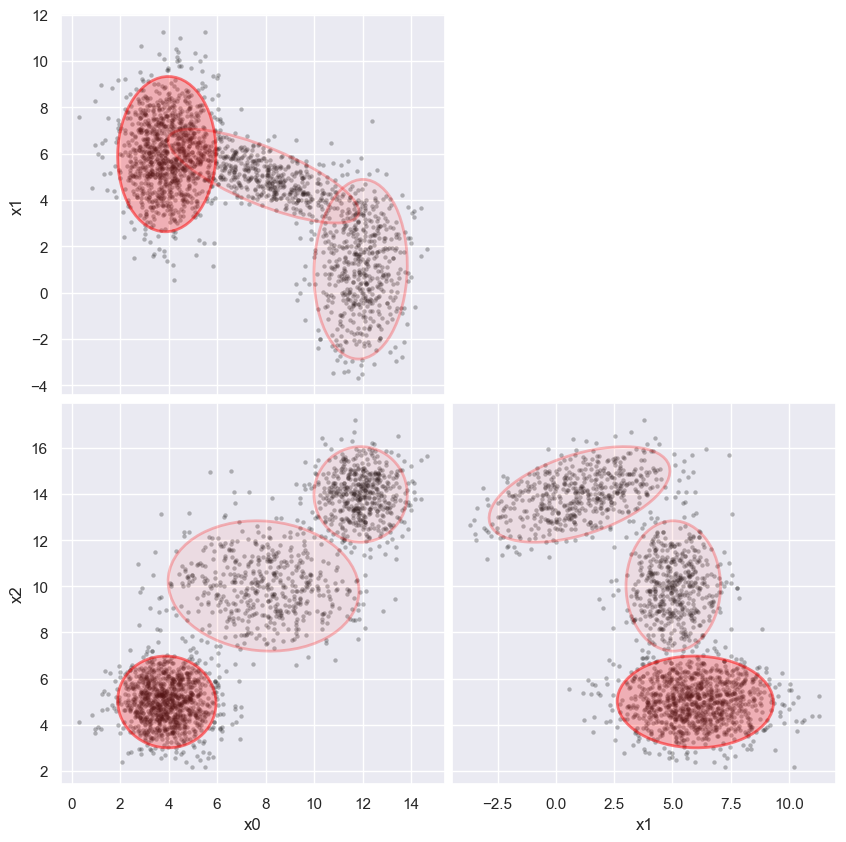

In [35]:
GMM_fit(blobs_data, 3)

Although GMM is primarily a density estimator, a GMM fit can also be used for clustering, with the advantage that we can calculate the relative probability of cluster membership for borderline samples. However, some care is required to interpret GMM for clustering since, unlike other clustering methods, GMM components can be highly overlapping and a single "visual cluster" is often fit with multiple Gaussians.

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:violet">EXERCISE</span>___: Fit the `cluster_data` loaded above, which is example (d) from earlier. Try different numbers of components to get a reasonable fit by eye. How do the printed values of AIC and BIC track the visual "goodness of fit"?

Since the visual clusters in the data are symmetric, the number of components $K$ should be even, allowing $K/2$ per cluster. The results look reasonable starting with $K = 8$ with a small improvement at $K = 10$, but no further improvement at larger $K$. Fits start to look worse at $K = 14$ as they latch onto noise fluctuations in the randomly generated samples.

AIC = 3186.266, BIC = 3434.928


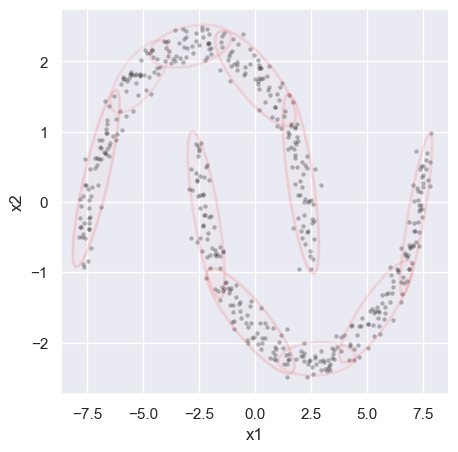

In [36]:
GMM_fit(cluster_data, 10)

The [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) and [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion) are different measures of the <span style="color:violet">goodness-of-fit</span> of the GMM to the data.  They both reward small residuals while penalizing extra fit parameters, to provide guidance on how many components to use.  However, both methods are ad-hoc and you should prefer the (more expensive) model selection methods we will see later whenever the answer really matters.

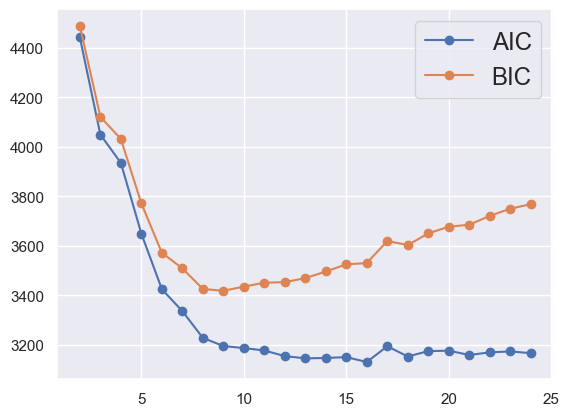

In [37]:
def plot_aic_bic(data, n_components=range(2, 25)):
    aic, bic = [], []
    for n in n_components:
        fit = mixture.GaussianMixture(n_components=n).fit(data)
        aic.append(fit.aic(data))
        bic.append(fit.bic(data))
    plt.plot(n_components, aic, '-o', label='AIC')
    plt.plot(n_components, bic, '-o', label='BIC')
    plt.legend(fontsize='x-large')
    
plot_aic_bic(cluster_data)

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

GMM is closely related to two other algorithms we have already encountered, `KMeans` and `FactorAnalysis`:
- All three use the versatile Expectation-Maximization (EM) method to achieve robust convergence.

- KMeans is a special case of GMM where each component's $C$ is reduced to a single parameter $\sigma$, via $C = \sigma^2 I$, and cluster membership weights are binary (0 or 1) rather than continuous (0-1).

- GMM implementations typically use KMeans to obtain its initial parameter values, before EM iterations.

- FactorAnalysis is an adaption of GMM with a single component for cases where the number of samples $N$ is insufficient to estimate the $D(D+1)/2$ indepdent elements of a full covariance matrix, so instead we assume a simpler (but non-diagonal) covariance with $N(D + 1)$ independent parameters.

## <span style="color:Orange">Extreme Deconvolution</span>

The [Extreme Convolution Method](https://arxiv.org/abs/0905.2979) seeks infer a complete probability distribution function from noisy, heterogeneous and incomplete observations (data). The algorithm is implemented in the AstroML package (see http://www.astroml.org/modules/generated/astroML.density_estimation.XDGMM.html)

In [38]:
def weighted_GMM(n_components, add_noise=None, data=blobs_data, limits=None, seed=123):
    gen = np.random.RandomState(seed=seed)
    noisy = data.copy()
    N, D = noisy.shape
    # Initialize zero errors.
    W = np.zeros((N, D, D))
    # Add some Gaussian noise with a linearly varying RMS, if requested.
    if add_noise:
        add_noise = np.asarray(add_noise)
        assert len(add_noise) == D
        diag = np.arange(D)
        W[:, diag, diag] = add_noise ** 2
        noisy += gen.normal(size=(N, D)) * add_noise
    # Perform the weighed "extreme deconvolution" fit.
    fit = astroML.density_estimation.XDGMM(n_components=n_components).fit(noisy, W)
    GMM_pairplot(noisy, fit.alpha, fit.mu, fit.V, limits=limits)

First fit without any errors added to the data. Fix the plot limits for easier comparisons below:

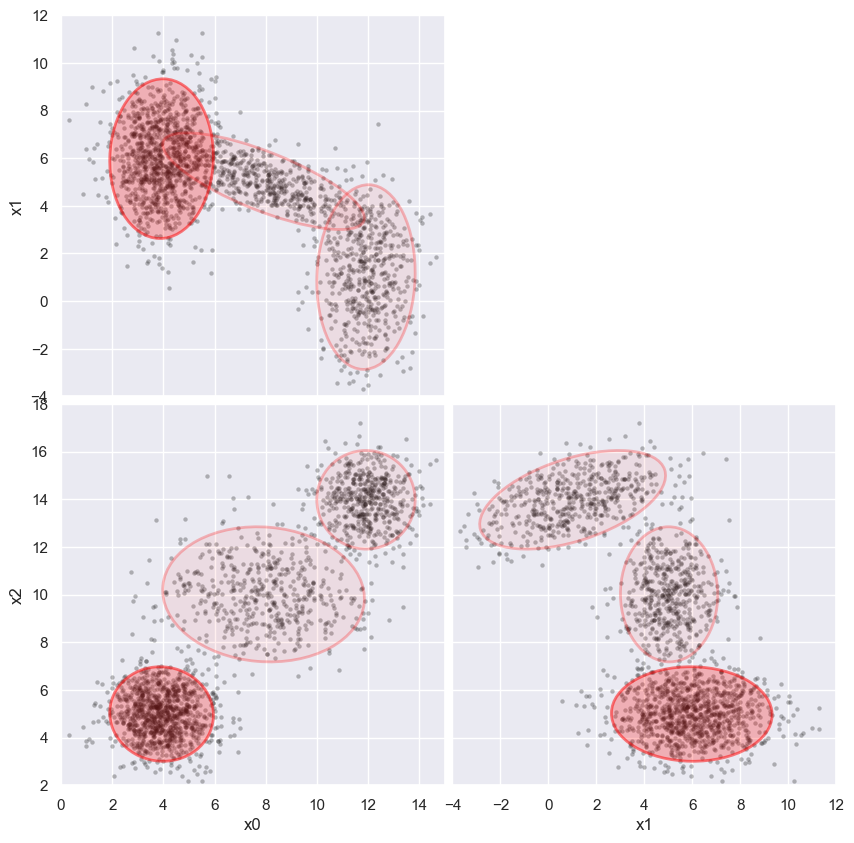

CPU times: user 1.59 s, sys: 1.15 s, total: 2.74 s
Wall time: 726 ms


In [39]:
%time weighted_GMM(3, limits=[(0,15), (-4,12), (2,18)])

Next, add errors to x0 only, and observe the effect on the scatter of x0 values below. The (x1, x2) projection of the fit is essentially unaffected while the (x0, x1) and (x0, x2) projections demonstrate that the fit is correcting for the added noise, with some expected loss of sensitivity.

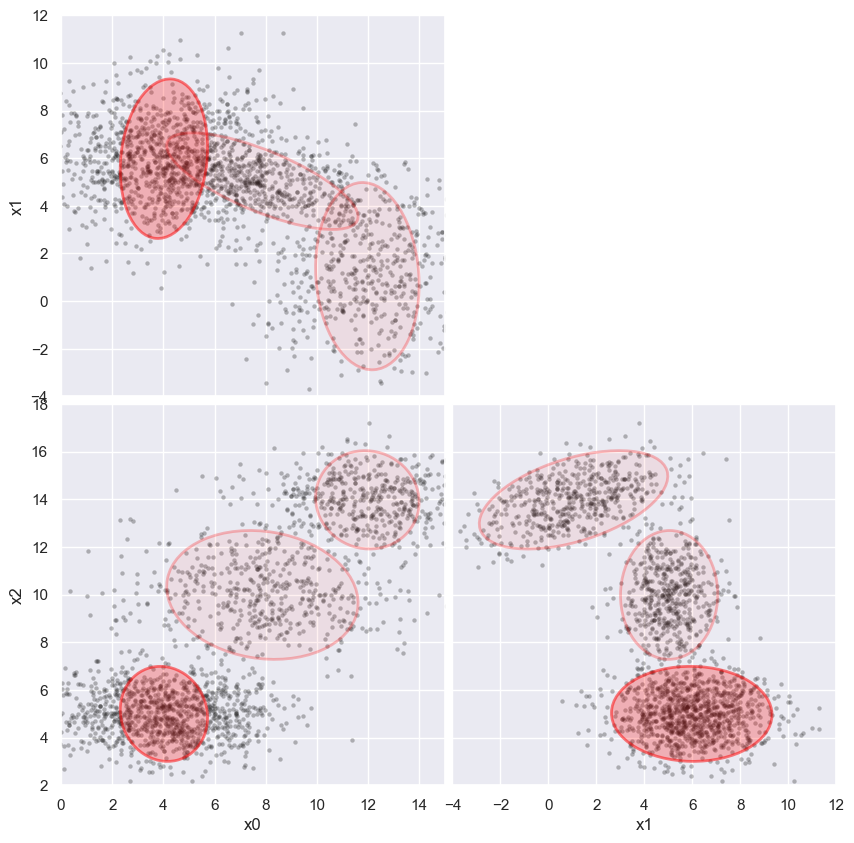

CPU times: user 10.3 s, sys: 1.26 s, total: 11.5 s
Wall time: 9.6 s


In [40]:
%time weighted_GMM(3, add_noise=(2, 0, 0), limits=[(0,15), (-4,12), (2,18)])

Finally, add more noise to see how far we can push this approach:

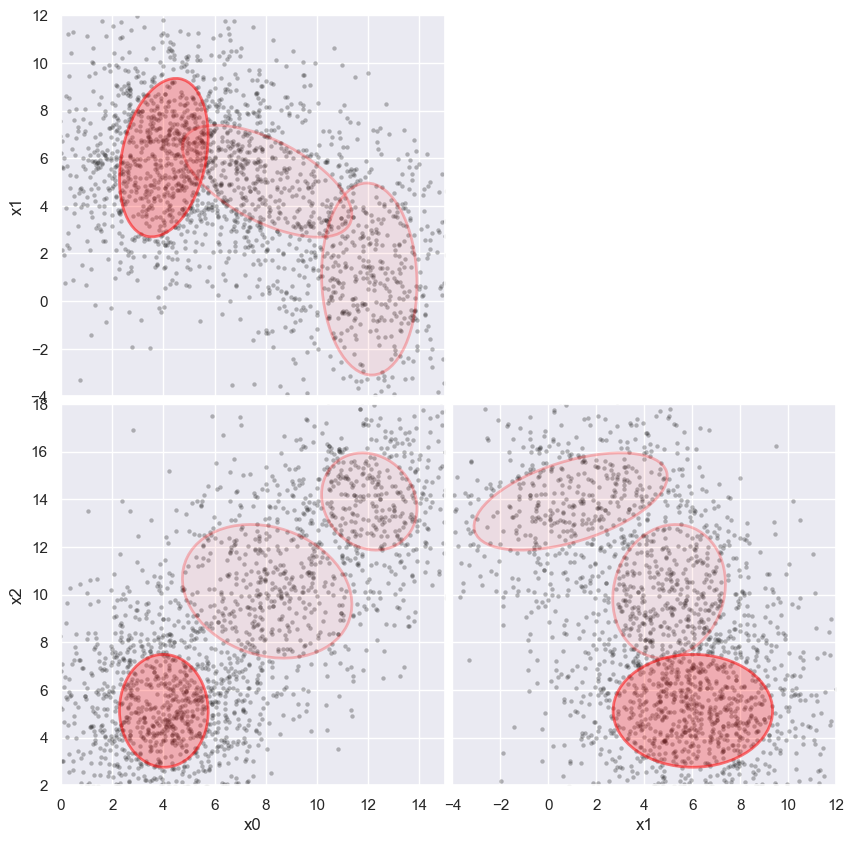

CPU times: user 10.3 s, sys: 1.22 s, total: 11.5 s
Wall time: 9.63 s


In [41]:
%time weighted_GMM(3, add_noise=(2, 2, 2), limits=[(0,15), (-4,12), (2,18)])

Note that errors slow down the fit substantially (although not with an obvious pattern). If this is an issue, the [original implementation of extreme deconvolution](https://github.com/jobovy/extreme-deconvolution) is faster and more flexible, but also more complex to install.

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer

© Copyright 2025